## Setup

In [1]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)

In [2]:
from tapas_gmm.policy.models.tpgmm import ModelType, TPGMM, ReconstructionStrategy, FittingStage, InitStrategy, _xdx_to_tangent, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
from lovely_numpy import lo
import matplotlib.pyplot as plt

import pathlib
#from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from tapas_gmm.dataset.demos import Demos, PartialFrameViewDemos
import tapas_gmm.policy.models.tpgmm
from tapas_gmm.utils.misc import load_scene_data, DataNamingConfig
from tapas_gmm.utils.logging import setup_logger  # noqa: F401
from tapas_gmm.viz.gmm import plot_log_map_quaternions, plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent / data_root.stem

np.set_printoptions(precision=2)

plt.style.use('default')

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='jshtml')


2025-08-05 03:48:25.761 | INFO     |  Running on cpu


In [3]:
task = "BlockDrawerPink"
path = data_root / task / "demos"

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)
print(scene_data.sample_data_point_with_ground_truth(cam="wrist"))

2025-08-05 03:48:31.932 | INFO     |  Loading dataset(s): 
2025-08-05 03:48:31.933 | INFO     |    Initializing datasete using /home/jangruhnert/Projects/TapasCalvin/data/BlockDrawerPink/demos/metadata.json
2025-08-05 03:48:31.940 | INFO     |    Extracted gt object labels [0, 1, 2, 3, 4, 5, 6]
2025-08-05 03:48:31.940 | INFO     |    Extracted tsdf object labels []
2025-08-05 03:48:31.940 | INFO     |    Done! Data contains 5 trajectories.
SingleCamSceneObservation(
    action=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    depth=Tensor(shape=torch.Size([256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
    ee_pose=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    extr=Tensor(shape=torch.Size([4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
    feedback=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
    intr=Tensor(shape=torch.Size([3, 3]), device=cpu, dtype

In [4]:
gt_pose_config = {}

gt_kp_config = {
    'encoder_name': 'demos_keypoints_gt_encoder-world',
    'cam': 'static',
}

kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'gtcopy',
}


In [5]:
observations = scene_data.get_demos(**gt_pose_config)
print(observations[0].keys())
print(observations[0])
n_obs = len(observations)

demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=False,
    kp_indeces=None,
    enforce_z_up=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True
)

demos = Demos(observations, **data_kwargs)
print(demos)

_LazyStackedTensorDictKeysView(['action', 'cameras', 'ee_pose', 'feedback', 'gripper_state', 'joint_pos', 'joint_vel', 'object_poses', 'object_states'],
    include_nested=False,
    leaves_only=False)
SceneObservation(
    action=Tensor(shape=torch.Size([193, 7]), device=cpu, dtype=torch.float32, is_shared=False),
    cameras=LazyStackedTensorDict(
        fields={
            _order: CameraOrder(
                order=('wrist',),
                batch_size=torch.Size([193]),
                device=None,
                is_shared=False),
            wrist: SingleCamObservation(
                depth=Tensor(shape=torch.Size([193, 256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
                extr=Tensor(shape=torch.Size([193, 4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
                intr=Tensor(shape=torch.Size([193, 3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                rgb=Tensor(shape=torch.Size([193, 3, 256, 256]), device=cpu, dt

In [6]:
tpgmm_config = TPGMMConfig(
    n_components=10,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=False,
    add_gripper_action=True,
    reg_shrink=1e-2,
    reg_diag=2e-4,
    reg_diag_gripper=2e-2,
    reg_em_finish_shrink=1e-2,
    reg_em_finish_diag=2e-4,
    reg_em_finish_diag_gripper=2e-2,
    trans_cov_mask_t_pos_corr=False,
    em_steps=50,
    fix_first_component=True,
    fix_last_component=True,
    reg_init_diag=5e-4,  # 5
    heal_time_variance=False,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.5,
    use_bic=False,
    drop_redundant_frames=False,
)

demos_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,
    repeat_final_step=10,
    repeat_first_step=0,
    components_prop_to_len=True,
    min_n_components=1,
    velocity_threshold=0.001,
    min_end_distance=16,
)

cascade_config = CascadeConfig(
    kl_keep_time_dim=True,
    kl_keep_rotation_dim=False,
)

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demos_segmentation_config,
    cascade=cascade_config,
)

In [7]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


2025-08-05 03:48:49.403 | INFO     |  Fitting AutoTPGMM
2025-08-05 03:48:49.403 | INFO     |  Performing fitting actions: [INIT]
2025-08-05 03:48:49.403 | INFO     |  Segmenting trajectories


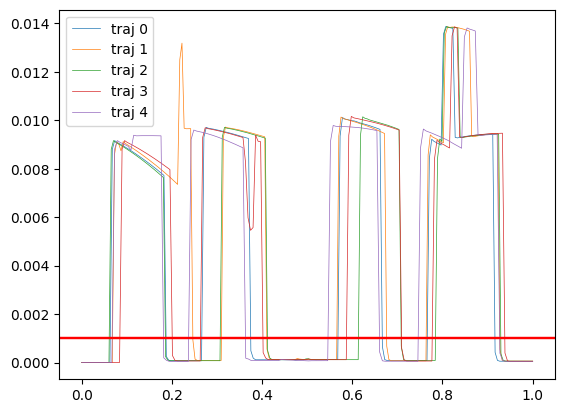

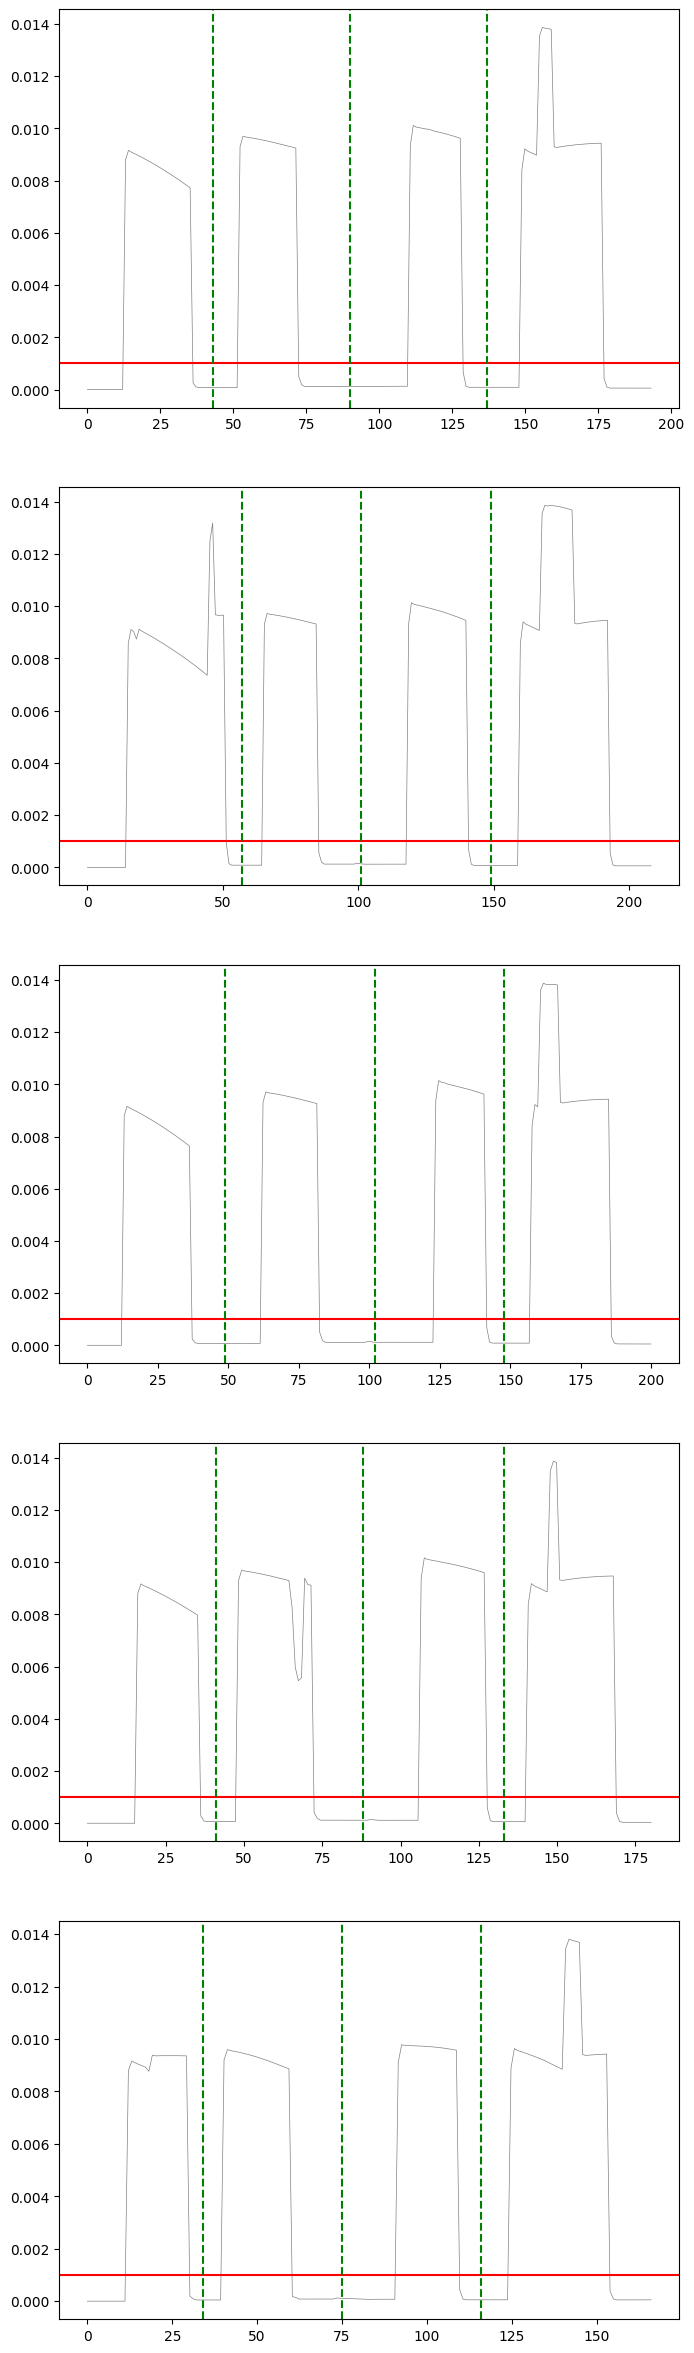

2025-08-05 03:48:50.789 | INFO     |  Creating segement of demos.
2025-08-05 03:48:50.800 | INFO     |  Subsampling to length 53 using strategy mean-length.
2025-08-05 03:48:50.803 | INFO     |  Creating segement of demos.
2025-08-05 03:48:50.817 | INFO     |  Subsampling to length 55 using strategy mean-length.
2025-08-05 03:48:50.819 | INFO     |  Creating segement of demos.
2025-08-05 03:48:50.829 | INFO     |  Subsampling to length 54 using strategy mean-length.
2025-08-05 03:48:50.831 | INFO     |  Creating segement of demos.
2025-08-05 03:48:50.840 | INFO     |  Subsampling to length 61 using strategy mean-length.
2025-08-05 03:48:50.842 | INFO     |  ... created 4 segments
2025-08-05 03:48:50.843 | INFO     |    Fitting candidate frame 1/10
2025-08-05 03:48:50.843 | INFO     |    Creating partial frame view of demos.
2025-08-05 03:48:50.852 | INFO     |    Manifold: TIME x R3 x QUAT x R1
2025-08-05 03:48:50.852 | INFO     |    Changing number of components to 1
2025-08-05 03:48:

Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:48:51.075 | INFO     |    Fitting candidate frame 2/10
2025-08-05 03:48:51.076 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:48:51.458 | INFO     |    Fitting candidate frame 3/10
2025-08-05 03:48:51.459 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:48:51.686 | INFO     |    Fitting candidate frame 4/10
2025-08-05 03:48:51.689 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:48:51.943 | INFO     |    Fitting candidate frame 5/10
2025-08-05 03:48:51.944 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:48:52.180 | INFO     |    Fitting candidate frame 6/10
2025-08-05 03:48:52.181 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:48:52.442 | INFO     |    Fitting candidate frame 7/10
2025-08-05 03:48:52.443 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:48:52.663 | INFO     |    Fitting candidate frame 8/10
2025-08-05 03:48:52.664 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:48:52.884 | INFO     |    Fitting candidate frame 9/10
2025-08-05 03:48:52.885 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:48:53.238 | INFO     |    Fitting candidate frame 10/10
2025-08-05 03:48:53.240 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:48:53.523 | INFO     |  ee_init    score (rel):     -0 (1.000)
2025-08-05 03:48:53.524 | INFO     |  obj000     score (rel):     -0 (1.000)
2025-08-05 03:48:53.524 | INFO     |  obj001     score (rel):     -0 (1.000)
2025-08-05 03:48:53.524 | INFO     |  obj002     score (rel):     -0 (1.000)
2025-08-05 03:48:53.525 | INFO     |  obj003     score (rel):     -0 (1.000)
2025-08-05 03:48:53.525 | INFO     |  obj004     score (rel):     -0 (1.000)
2025-08-05 03:48:53.525 | INFO     |  obj005     score (rel):     -0 (1.000)
2025-08-05 03:48:53.525 | INFO     |  obj006     score (rel):     -0 (0.026)
2025-08-05 03:48:53.525 | INFO     |  obj007     score (rel):     -0 (0.017)
2025-08-05 03:48:53.525 | INFO     |  obj008     score (rel):     -0 (0.459)
2025-08-05 03:48:53.526 | INFO     |  Creating partial frame view of demos.
2025-08-05 03:48:53.641 | INFO     |    Fitting candidate frame 1/10
2025-08-05 03:48:53.642 | INFO     |    Creating partial frame view of demos.
2025-08

Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:48:53.901 | INFO     |    Fitting candidate frame 2/10
2025-08-05 03:48:53.901 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:48:54.143 | INFO     |    Fitting candidate frame 3/10
2025-08-05 03:48:54.144 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:48:54.428 | INFO     |    Fitting candidate frame 4/10
2025-08-05 03:48:54.429 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:48:54.715 | INFO     |    Fitting candidate frame 5/10
2025-08-05 03:48:54.716 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:48:55.192 | INFO     |    Fitting candidate frame 6/10
2025-08-05 03:48:55.196 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:48:55.537 | INFO     |    Fitting candidate frame 7/10
2025-08-05 03:48:55.538 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:48:55.846 | INFO     |    Fitting candidate frame 8/10
2025-08-05 03:48:55.847 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:48:56.098 | INFO     |    Fitting candidate frame 9/10
2025-08-05 03:48:56.099 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:48:56.330 | INFO     |    Fitting candidate frame 10/10
2025-08-05 03:48:56.331 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:48:56.567 | INFO     |  ee_init    score (rel):     -0 (0.097)
2025-08-05 03:48:56.568 | INFO     |  obj000     score (rel):     -0 (0.097)
2025-08-05 03:48:56.568 | INFO     |  obj001     score (rel):     -0 (0.097)
2025-08-05 03:48:56.568 | INFO     |  obj002     score (rel):     -0 (0.097)
2025-08-05 03:48:56.569 | INFO     |  obj003     score (rel):     -0 (0.097)
2025-08-05 03:48:56.569 | INFO     |  obj004     score (rel):     -0 (0.097)
2025-08-05 03:48:56.569 | INFO     |  obj005     score (rel):     -0 (0.097)
2025-08-05 03:48:56.569 | INFO     |  obj006     score (rel):     -0 (0.004)
2025-08-05 03:48:56.569 | INFO     |  obj007     score (rel):     -0 (0.002)
2025-08-05 03:48:56.569 | INFO     |  obj008     score (rel):     -1 (1.000)
2025-08-05 03:48:56.569 | WARNING  |  Selected frames for segments 0 and 1 are disjoint. 
2025-08-05 03:48:56.580 | INFO     |  Adding frame 0 to segment 1.
2025-08-05 03:48:56.581 | INFO     |  Creating partial frame view of demo

Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:48:56.780 | INFO     |    Fitting candidate frame 2/10
2025-08-05 03:48:56.781 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:48:57.095 | INFO     |    Fitting candidate frame 3/10
2025-08-05 03:48:57.096 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:48:57.453 | INFO     |    Fitting candidate frame 4/10
2025-08-05 03:48:57.455 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:48:57.697 | INFO     |    Fitting candidate frame 5/10
2025-08-05 03:48:57.697 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:48:57.975 | INFO     |    Fitting candidate frame 6/10
2025-08-05 03:48:57.976 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:48:58.181 | INFO     |    Fitting candidate frame 7/10
2025-08-05 03:48:58.182 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:48:58.429 | INFO     |    Fitting candidate frame 8/10
2025-08-05 03:48:58.429 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:48:58.650 | INFO     |    Fitting candidate frame 9/10
2025-08-05 03:48:58.652 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:48:58.865 | INFO     |    Fitting candidate frame 10/10
2025-08-05 03:48:58.866 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:48:59.106 | INFO     |  ee_init    score (rel):     -0 (0.117)
2025-08-05 03:48:59.109 | INFO     |  obj000     score (rel):     -0 (0.117)
2025-08-05 03:48:59.109 | INFO     |  obj001     score (rel):     -0 (0.117)
2025-08-05 03:48:59.109 | INFO     |  obj002     score (rel):     -0 (0.117)
2025-08-05 03:48:59.110 | INFO     |  obj003     score (rel):     -0 (0.117)
2025-08-05 03:48:59.110 | INFO     |  obj004     score (rel):     -0 (0.117)
2025-08-05 03:48:59.110 | INFO     |  obj005     score (rel):     -0 (0.117)
2025-08-05 03:48:59.110 | INFO     |  obj006     score (rel):     -0 (0.005)
2025-08-05 03:48:59.111 | INFO     |  Creating partial frame view of demos.
2025-08-05 03:48:59.114 | INFO     |    Fitting candidate frame 1/10
2025-08-05 03:48:59.114 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:48:59.536 | INFO     |    Fitting candidate frame 2/10
2025-08-05 03:48:59.537 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:48:59.876 | INFO     |    Fitting candidate frame 3/10
2025-08-05 03:48:59.877 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:49:00.150 | INFO     |    Fitting candidate frame 4/10
2025-08-05 03:49:00.154 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:49:00.413 | INFO     |    Fitting candidate frame 5/10
2025-08-05 03:49:00.414 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:49:00.663 | INFO     |    Fitting candidate frame 6/10
2025-08-05 03:49:00.664 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:49:00.960 | INFO     |    Fitting candidate frame 7/10
2025-08-05 03:49:00.962 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:49:01.295 | INFO     |    Fitting candidate frame 8/10
2025-08-05 03:49:01.296 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:49:01.610 | INFO     |    Fitting candidate frame 9/10
2025-08-05 03:49:01.611 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:49:02.062 | INFO     |    Fitting candidate frame 10/10
2025-08-05 03:49:02.063 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:49:02.476 | INFO     |  ee_init    score (rel):     -0 (0.266)
2025-08-05 03:49:02.477 | INFO     |  obj000     score (rel):     -0 (0.266)
2025-08-05 03:49:02.477 | INFO     |  obj001     score (rel):     -0 (0.266)
2025-08-05 03:49:02.477 | INFO     |  obj002     score (rel):     -0 (0.266)
2025-08-05 03:49:02.477 | INFO     |  obj003     score (rel):     -0 (0.266)
2025-08-05 03:49:02.477 | INFO     |  obj004     score (rel):     -0 (0.266)
2025-08-05 03:49:02.477 | INFO     |  obj005     score (rel):     -0 (0.266)
2025-08-05 03:49:02.478 | INFO     |  obj006     score (rel):     -0 (0.016)
2025-08-05 03:49:02.478 | INFO     |  obj007     score (rel):     -0 (0.009)
2025-08-05 03:49:02.480 | INFO     |  Creating partial frame view of demos.
2025-08-05 03:49:02.483 | INFO     |  Segmented trajs into 4 segments
2025-08-05 03:49:02.529 | INFO     |  Frame score (abs):
            ee_init    obj000    obj001    obj002    obj003    obj004  \
Segment 0 -0.133297 -0.133296 -

Fitting segments:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 03:49:02.569 | INFO     |  Manifold: TIME x R3 x QUAT x R3 x QUAT x R3 x QUAT x R3 x QUAT x R3 x QUAT x R3 x QUAT x R3 x QUAT x R1
2025-08-05 03:49:02.570 | INFO     |  Changing number of components to 3


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-05 03:49:04.284 | INFO     |  Manifold: TIME x R3 x QUAT x R3 x QUAT x R1


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

((array([[3.82e+054, 3.82e+054, 3.72e+054, 3.51e+054, 3.23e+054, 2.89e+054,
          2.51e+054, 2.12e+054, 1.74e+054, 1.39e+054, 1.08e+054, 8.15e+053,
          5.98e+053, 4.27e+053, 1.73e+053, 2.11e+052, 7.90e+050, 9.31e+048,
          3.52e+046, 4.37e+043, 1.82e+040, 2.61e+036, 1.32e+032, 2.37e+027,
          1.59e+022, 4.07e+016, 4.06e+010, 1.95e+010, 7.59e+003, 1.21e-003,
          8.20e-011, 2.41e-018, 3.18e-026, 1.93e-034, 5.55e-043, 7.81e-052,
          5.55e-061, 2.05e-070, 3.64e-071, 1.64e-071, 6.69e-072, 2.66e-072,
          1.03e-072, 3.85e-073, 1.15e-073, 3.34e-074, 9.42e-075, 2.58e-075,
          6.89e-076, 1.79e-076, 4.51e-077, 1.11e-077, 2.64e-078, 3.82e+054,
          3.82e+054, 3.72e+054, 3.51e+054, 3.23e+054, 2.89e+054, 2.51e+054,
          2.12e+054, 1.74e+054, 1.39e+054, 1.08e+054, 8.15e+053, 5.98e+053,
          2.56e+053, 2.03e+051, 1.04e+051, 1.92e+050, 1.11e+049, 2.07e+047,
          4.43e+042, 3.21e+039, 8.09e+035, 4.66e+027, 6.15e+022, 3.15e+017,
          6.

In [8]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       fitting_actions=(FittingStage.INIT,)) # FittingStage.EM_HMM))


2025-08-05 03:49:05.902 | INFO     |  Did not specify time_based, deciding automatically.
2025-08-05 03:49:06.387 | WARNING  |  Skippig NaN Gaussians.


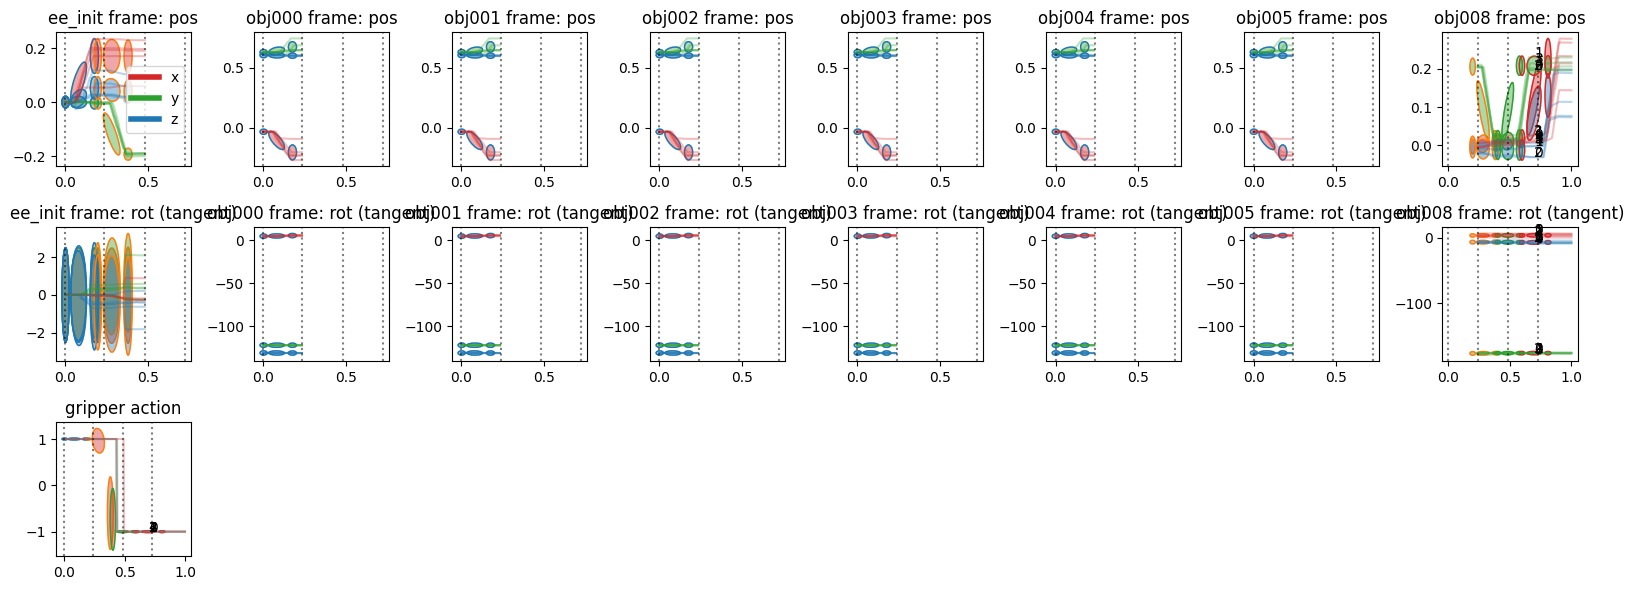

In [9]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=False, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False) #, size=(150, 10))


In [10]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       fitting_actions=(FittingStage.EM_HMM, ))


2025-08-05 03:49:13.803 | INFO     |  Fitting AutoTPGMM
2025-08-05 03:49:13.803 | INFO     |  Performing fitting actions: [EM_HMM]


Fitting segments:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 03:49:13.823 | INFO     |  HMM EM ...
2025-08-05 03:49:13.850 | INFO     |  HMM transition matrix not defined, initializing to uniform


HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

2025-08-05 03:49:14.073 | INFO     |  HMM init priors not defined, initializing to uniform
2025-08-05 03:49:20.373 | INFO     |  HMM EM converged


HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

((array([[1.05e-013, 1.01e-015, 7.93e-018, 5.03e-020, 2.57e-022, 1.04e-024,
          3.36e-027, 8.49e-030, 1.67e-032, 2.55e-035, 2.98e-038, 2.66e-041,
          1.79e-044, 9.03e-048, 1.62e-051, 3.12e-056, 2.03e-062, 1.43e-070,
          3.55e-081, 1.04e-094, 1.21e-111, 1.96e-132, 1.57e-157, 2.26e-187,
          2.20e-222, 5.65e-263, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 1.05e-013,
          1.01e-015, 7.93e-018, 5.03e-020, 2.57e-022, 1.04e-024, 3.36e-027,
          8.49e-030, 1.67e-032, 2.55e-035, 2.98e-038, 2.66e-041, 1.79e-044,
          6.97e-048, 6.84e-053, 2.95e-058, 1.97e-064, 6.51e-072, 3.47e-081,
          2.76e-095, 1.45e-112, 1.76e-133, 1.02e-162, 7.56e-197, 2.83e-236,
          0.

2025-08-05 03:49:28.902 | INFO     |  Did not specify time_based, deciding automatically.


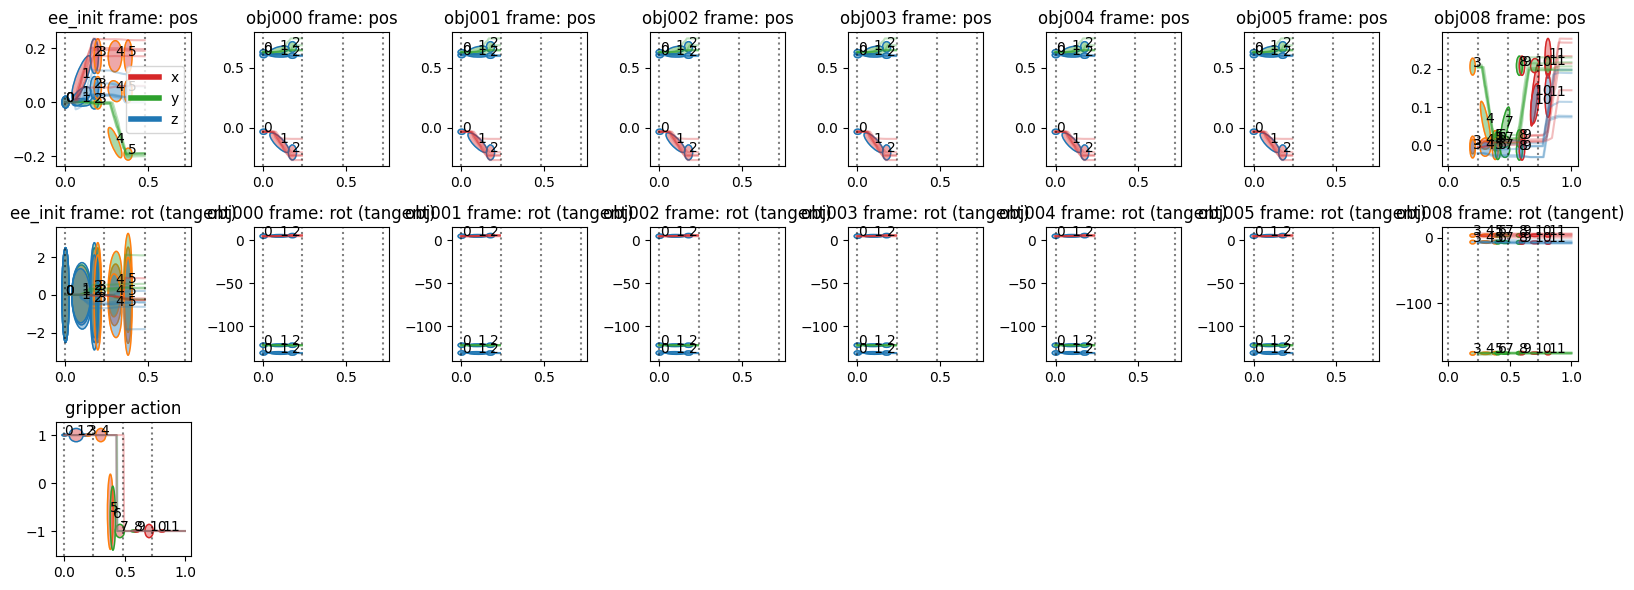

In [11]:

atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False)

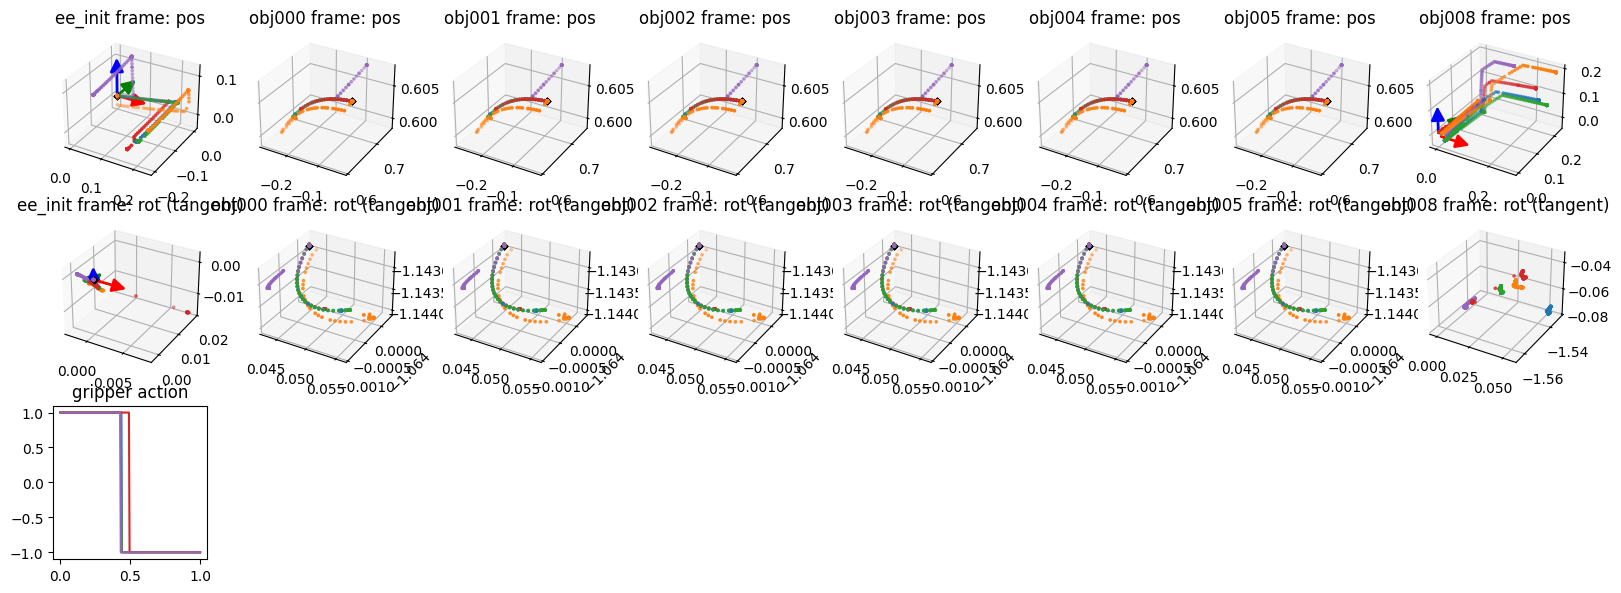

In [12]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False, time_based=False)

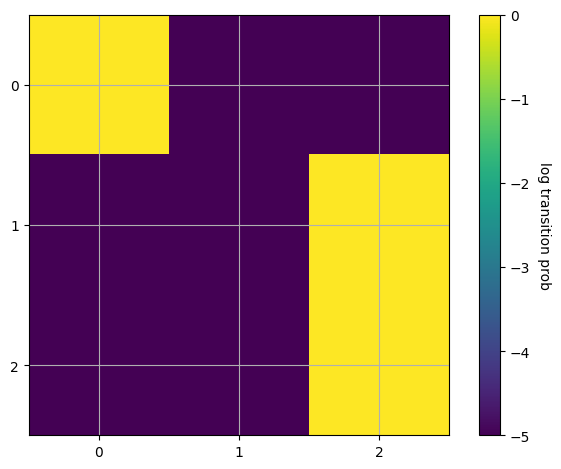

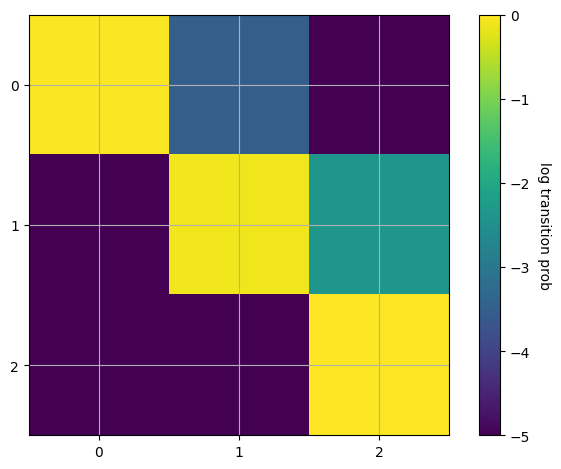

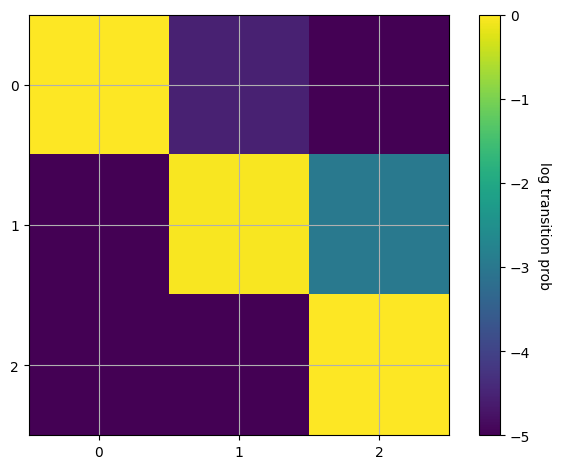

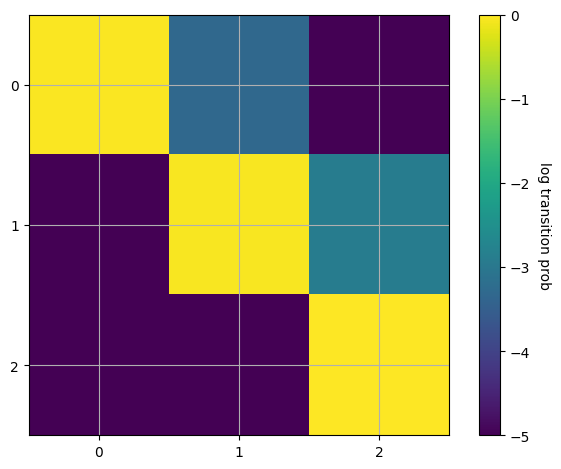

In [13]:
atpgmm.plot_hmm_transition_matrix()

In [14]:
atpgmm.to_disk(data_root / task / 'demos_gmm_policy-release.pt')

2025-08-05 03:49:45.317 | INFO     |  Saving model:


In [15]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=tapas_gmm.policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


2025-08-05 03:49:45.699 | INFO     |  Time-based reconstruction not specified. Auto selected True.
2025-08-05 03:49:45.819 | INFO     |  Caculated segment transition probabilities: (array([[1.]]), array([[1.]]), array([[1.]]))
2025-08-05 03:49:45.819 | INFO     |  Creating partial frame view of demos.
2025-08-05 03:49:45.936 | INFO     |  Assuming zero frame velocity. Should be fixed.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 03:49:47.098 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 03:49:47.375 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 03:49:47.504 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 03:49:47.602 | WARNING  |  Setting init priors of later segments to zero.


GMR:   0%|          | 0/5 [00:00<?, ?it/s]

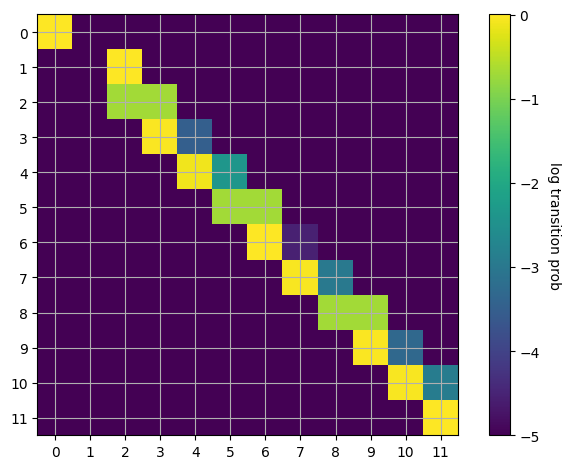

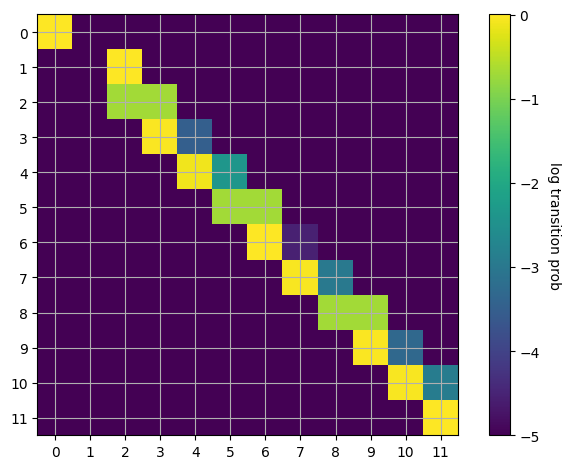

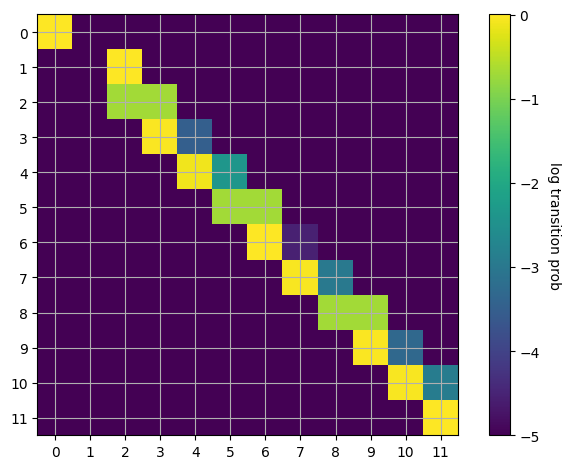

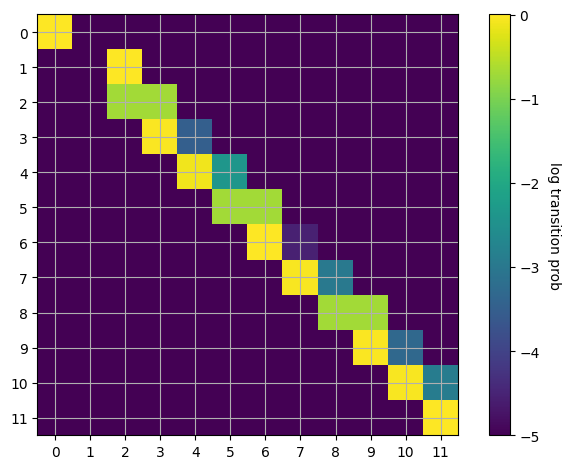

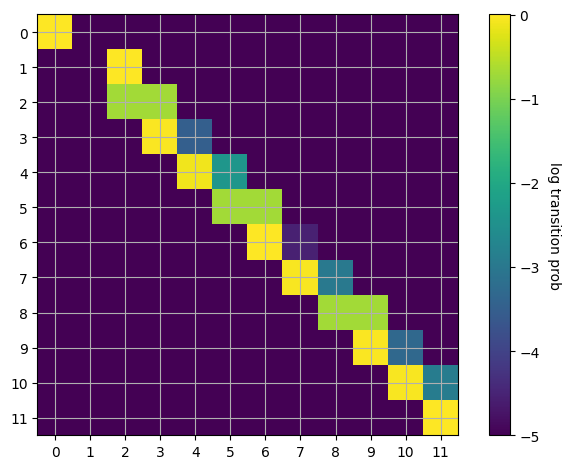

In [16]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)

2025-08-05 03:50:04.897 | INFO     |  Taking frame origins from demos.


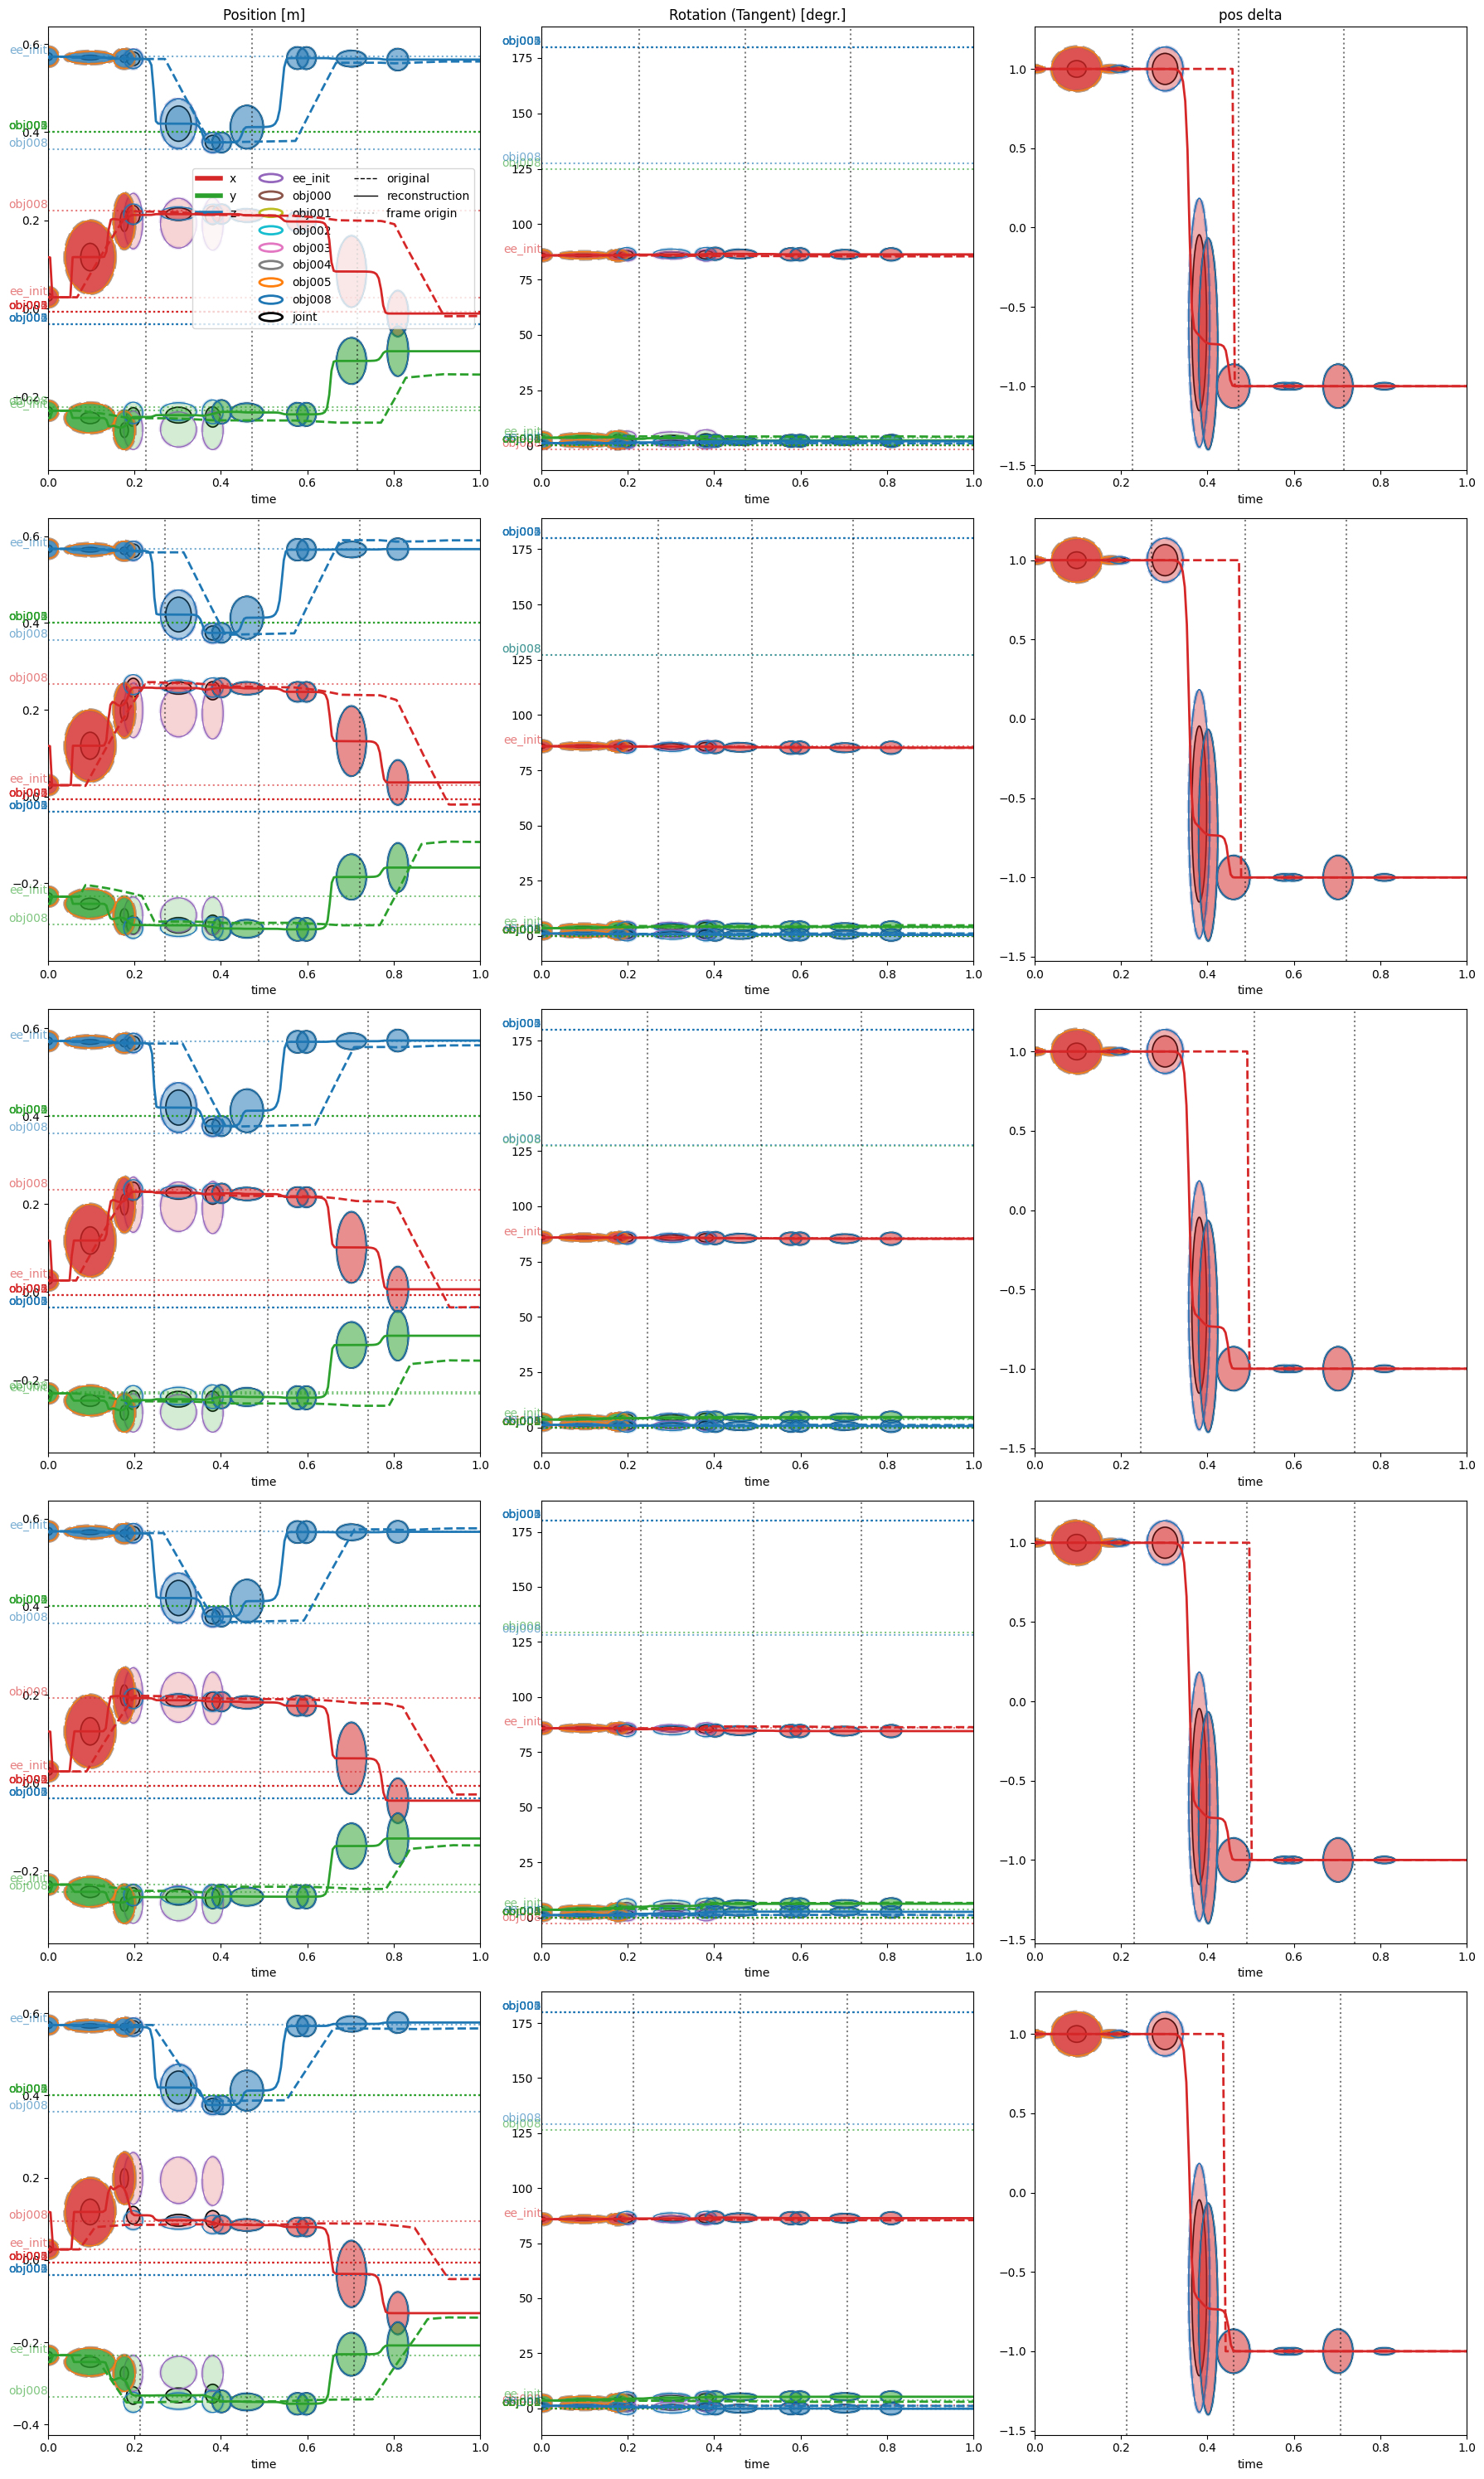

In [17]:

atpgmm.plot_reconstructions(
    seg_trans_marg_container, cascaded_hmms, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=True, equal_aspect=False, per_segment=False)


In [ ]:
atpgmm.plot_reconstructions(
    seg_trans_marginals, seg_joint_models, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=False, equal_aspect=True, per_segment=False)


IndexError: tuple index out of range

: 